In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
imageDir = 'test_images/'
imageFiles = os.listdir(imageDir)

imageList = []

for i in range(0, len(imageFiles)):
    imageList.append(mpimg.imread(imageDir + imageFiles[i]))

#print(imageFiles)

def display_images(images, cmap=None):
    plt.figure(figsize=(40,40))
    for i, image in enumerate(images):
        plt.subplot(3,2,i+1)
        plt.imshow(image,cmap)
        plt.autoscale(tight=True)
    plt.show(block=True)

display_images(imageList)

Output hidden; open in https://colab.research.google.com to view.

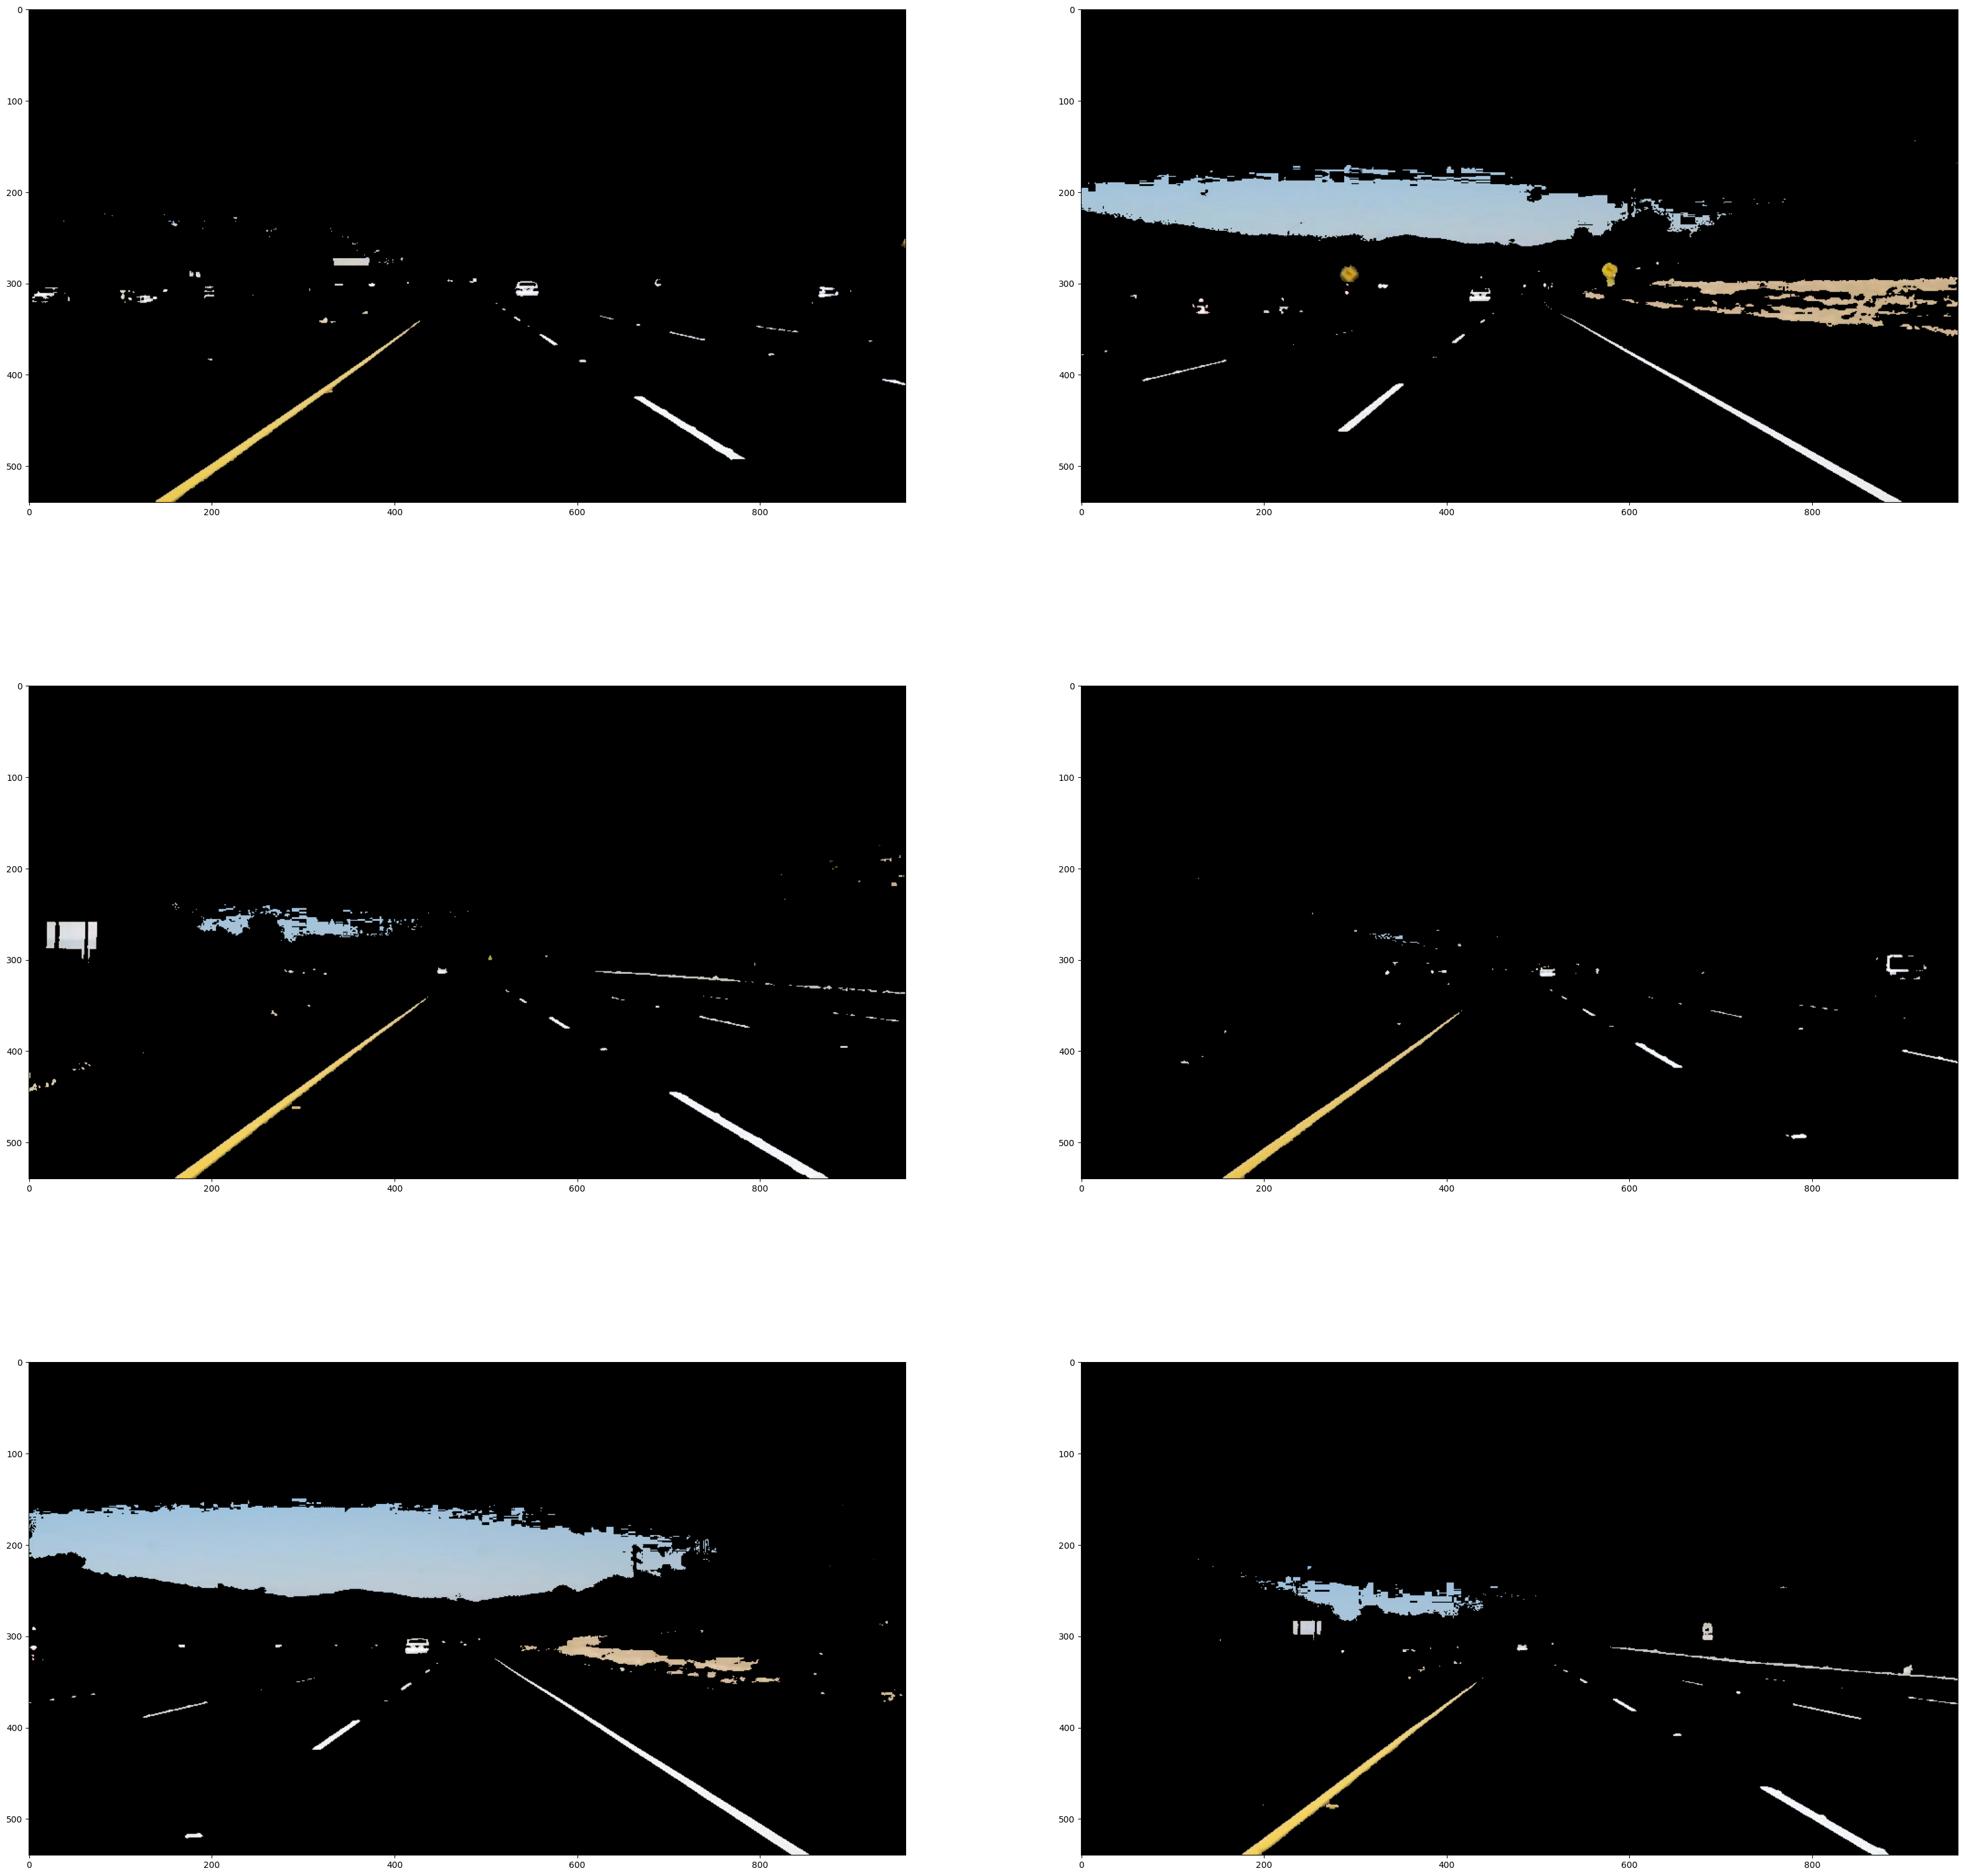

In [ ]:
#using HSL colorspace to filter out white and yellow
def color_filter(image):
    #convert to HLS to mask based on HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([0,190,0])
    upper = np.array([255,255,255])

    yellower = np.array([10,0,90])
    yelupper = np.array([50,255,255])

    yellowmask = cv2.inRange(hls, yellower, yelupper)
    whitemask = cv2.inRange(hls, lower, upper)

    mask = cv2.bitwise_or(yellowmask, whitemask)
    masked = cv2.bitwise_and(image, image, mask = mask)



    return masked

filtered_img = list(map(color_filter, imageList))

display_images(filtered_img)

Region of Interest

-masking out everything outside of region of interest




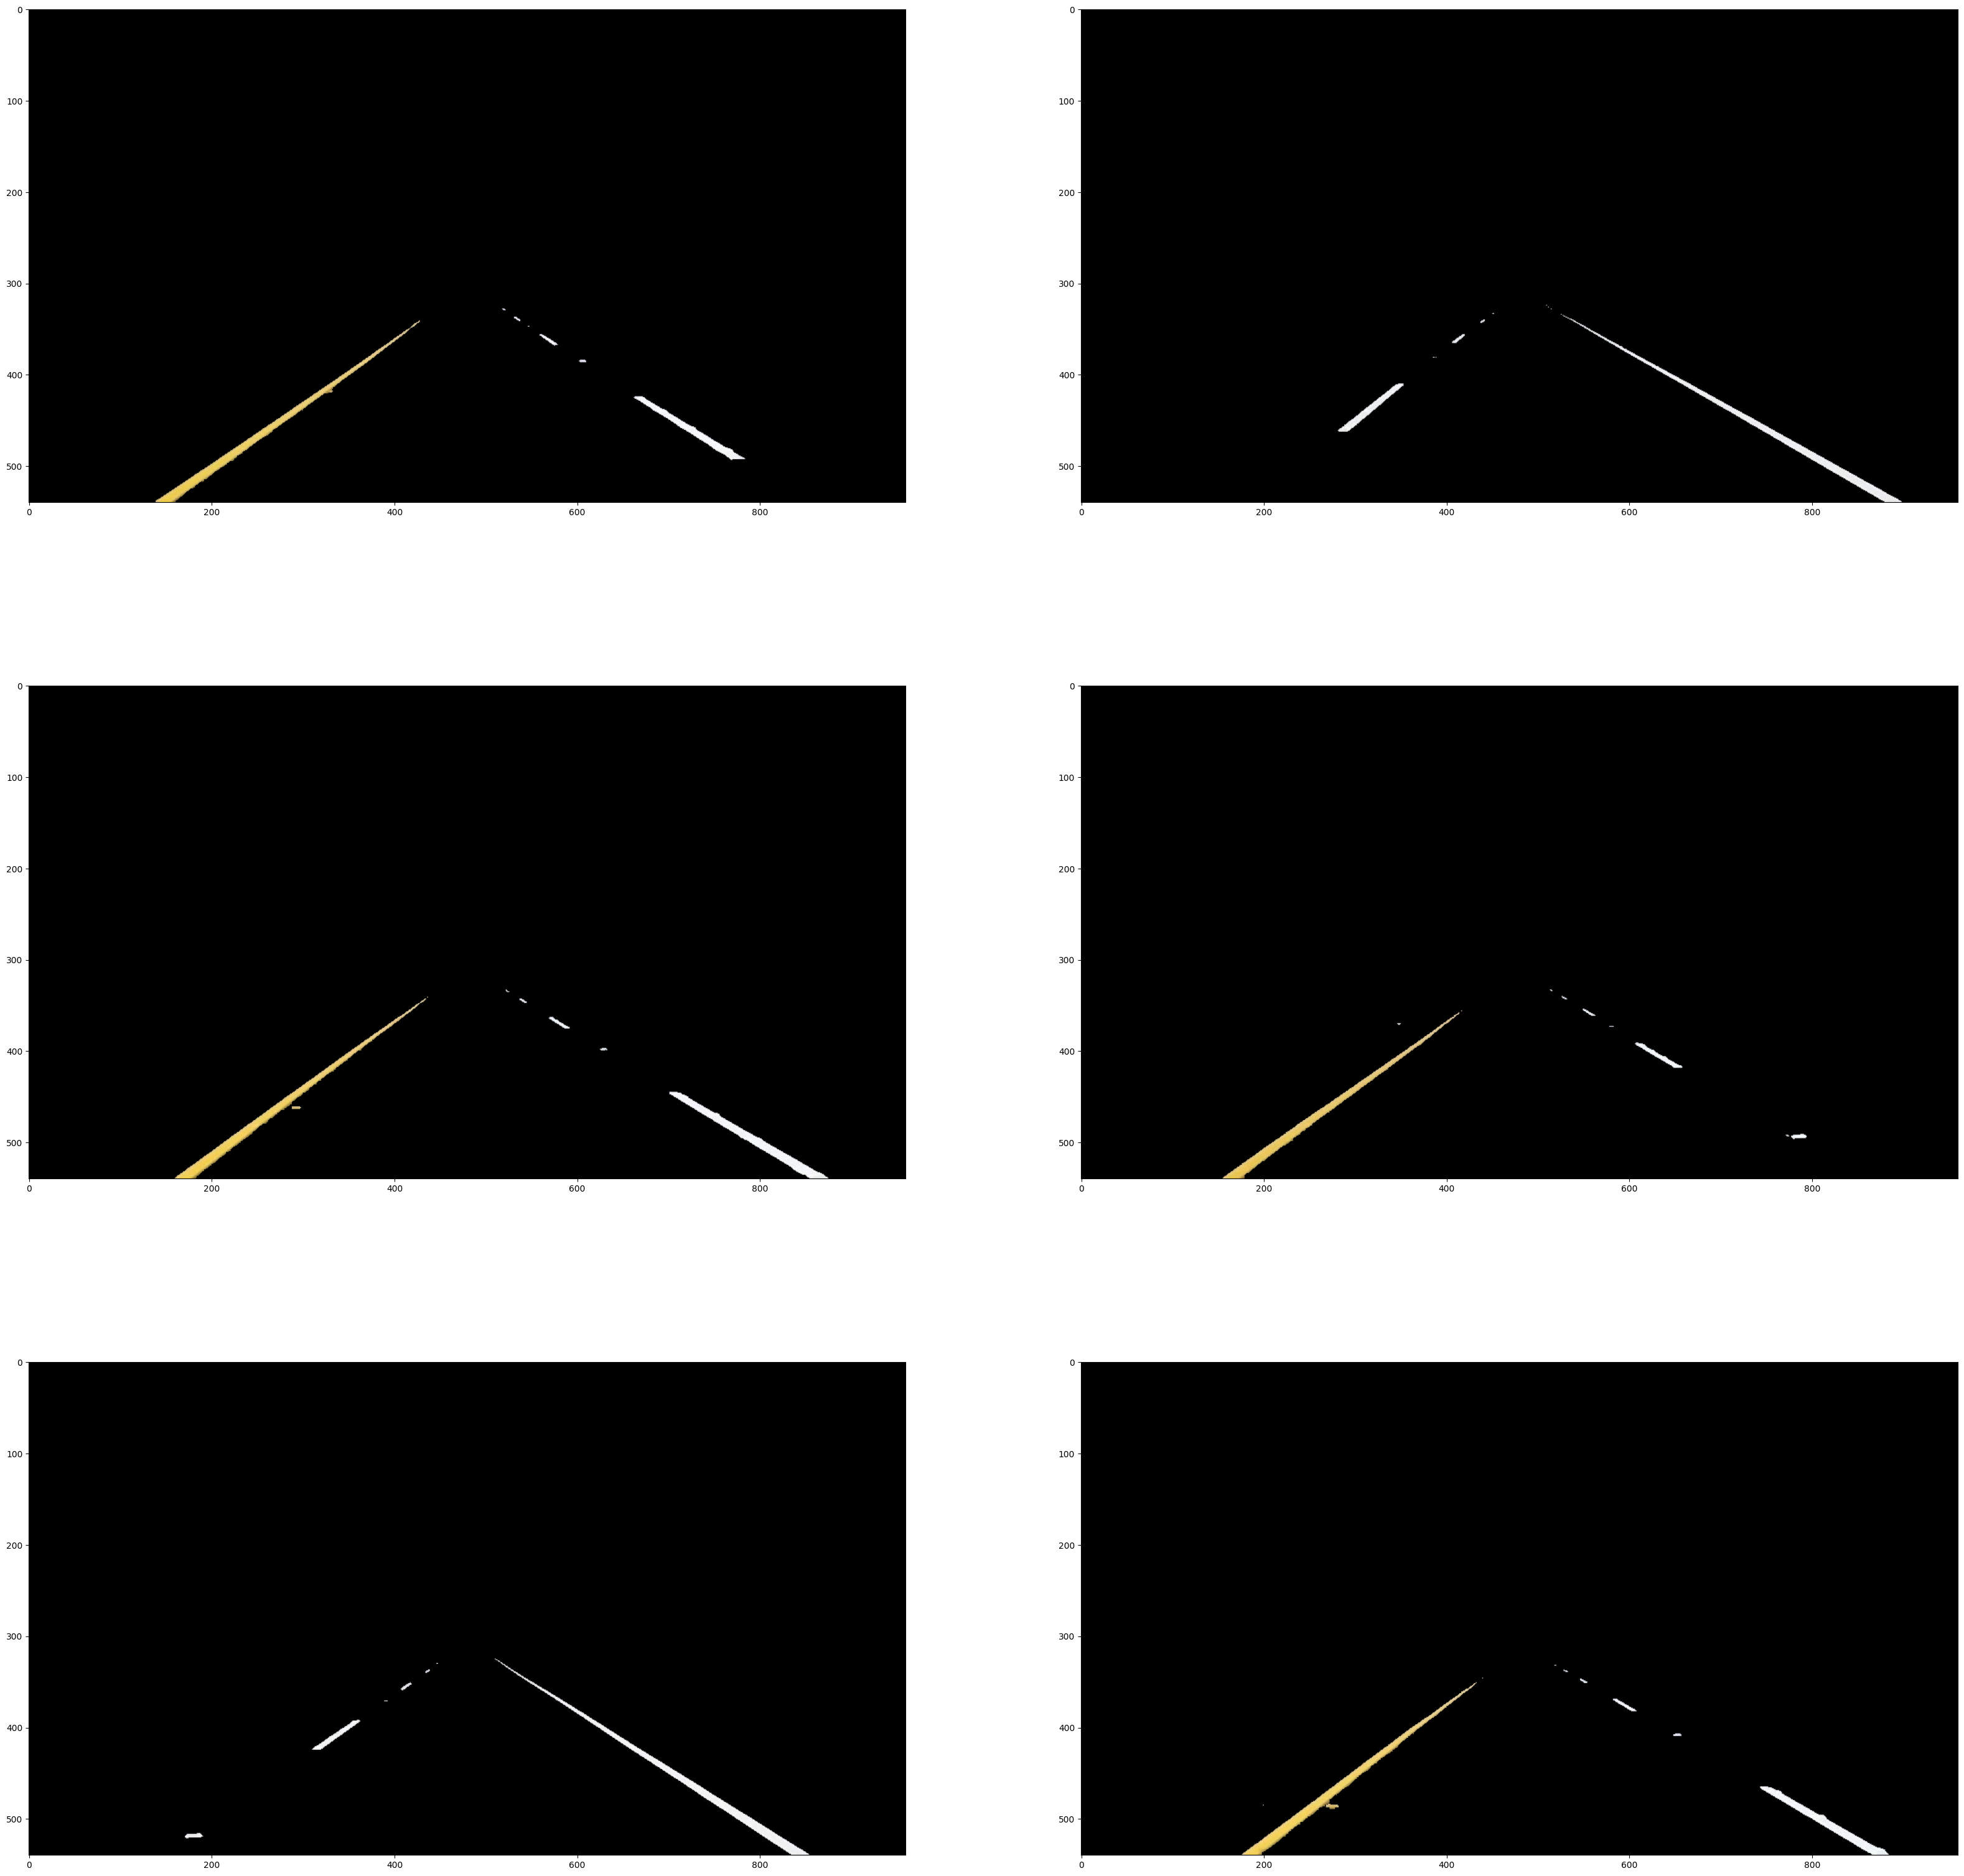

In [ ]:
def roi(img):
  x = int(img.shape[1])
  y = int(img.shape[0])
  shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])

  mask = np.zeros_like(img)

  if len(img.shape) > 2:
    channel_count = img.shape[2]
    ignore_mask_color = (255,) * channel_count
  else:
    ignore_mask_color = 255

  #creates polygon with mask color
  cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)

  masked_image = cv2.bitwise_and(img, mask)
  return masked_image

roi_img = list(map(roi, filtered_img))

display_images(roi_img)

Edge Detection
-use canny edge detection by converting image to grayscale and computing gradient of pixels adjecent to each other

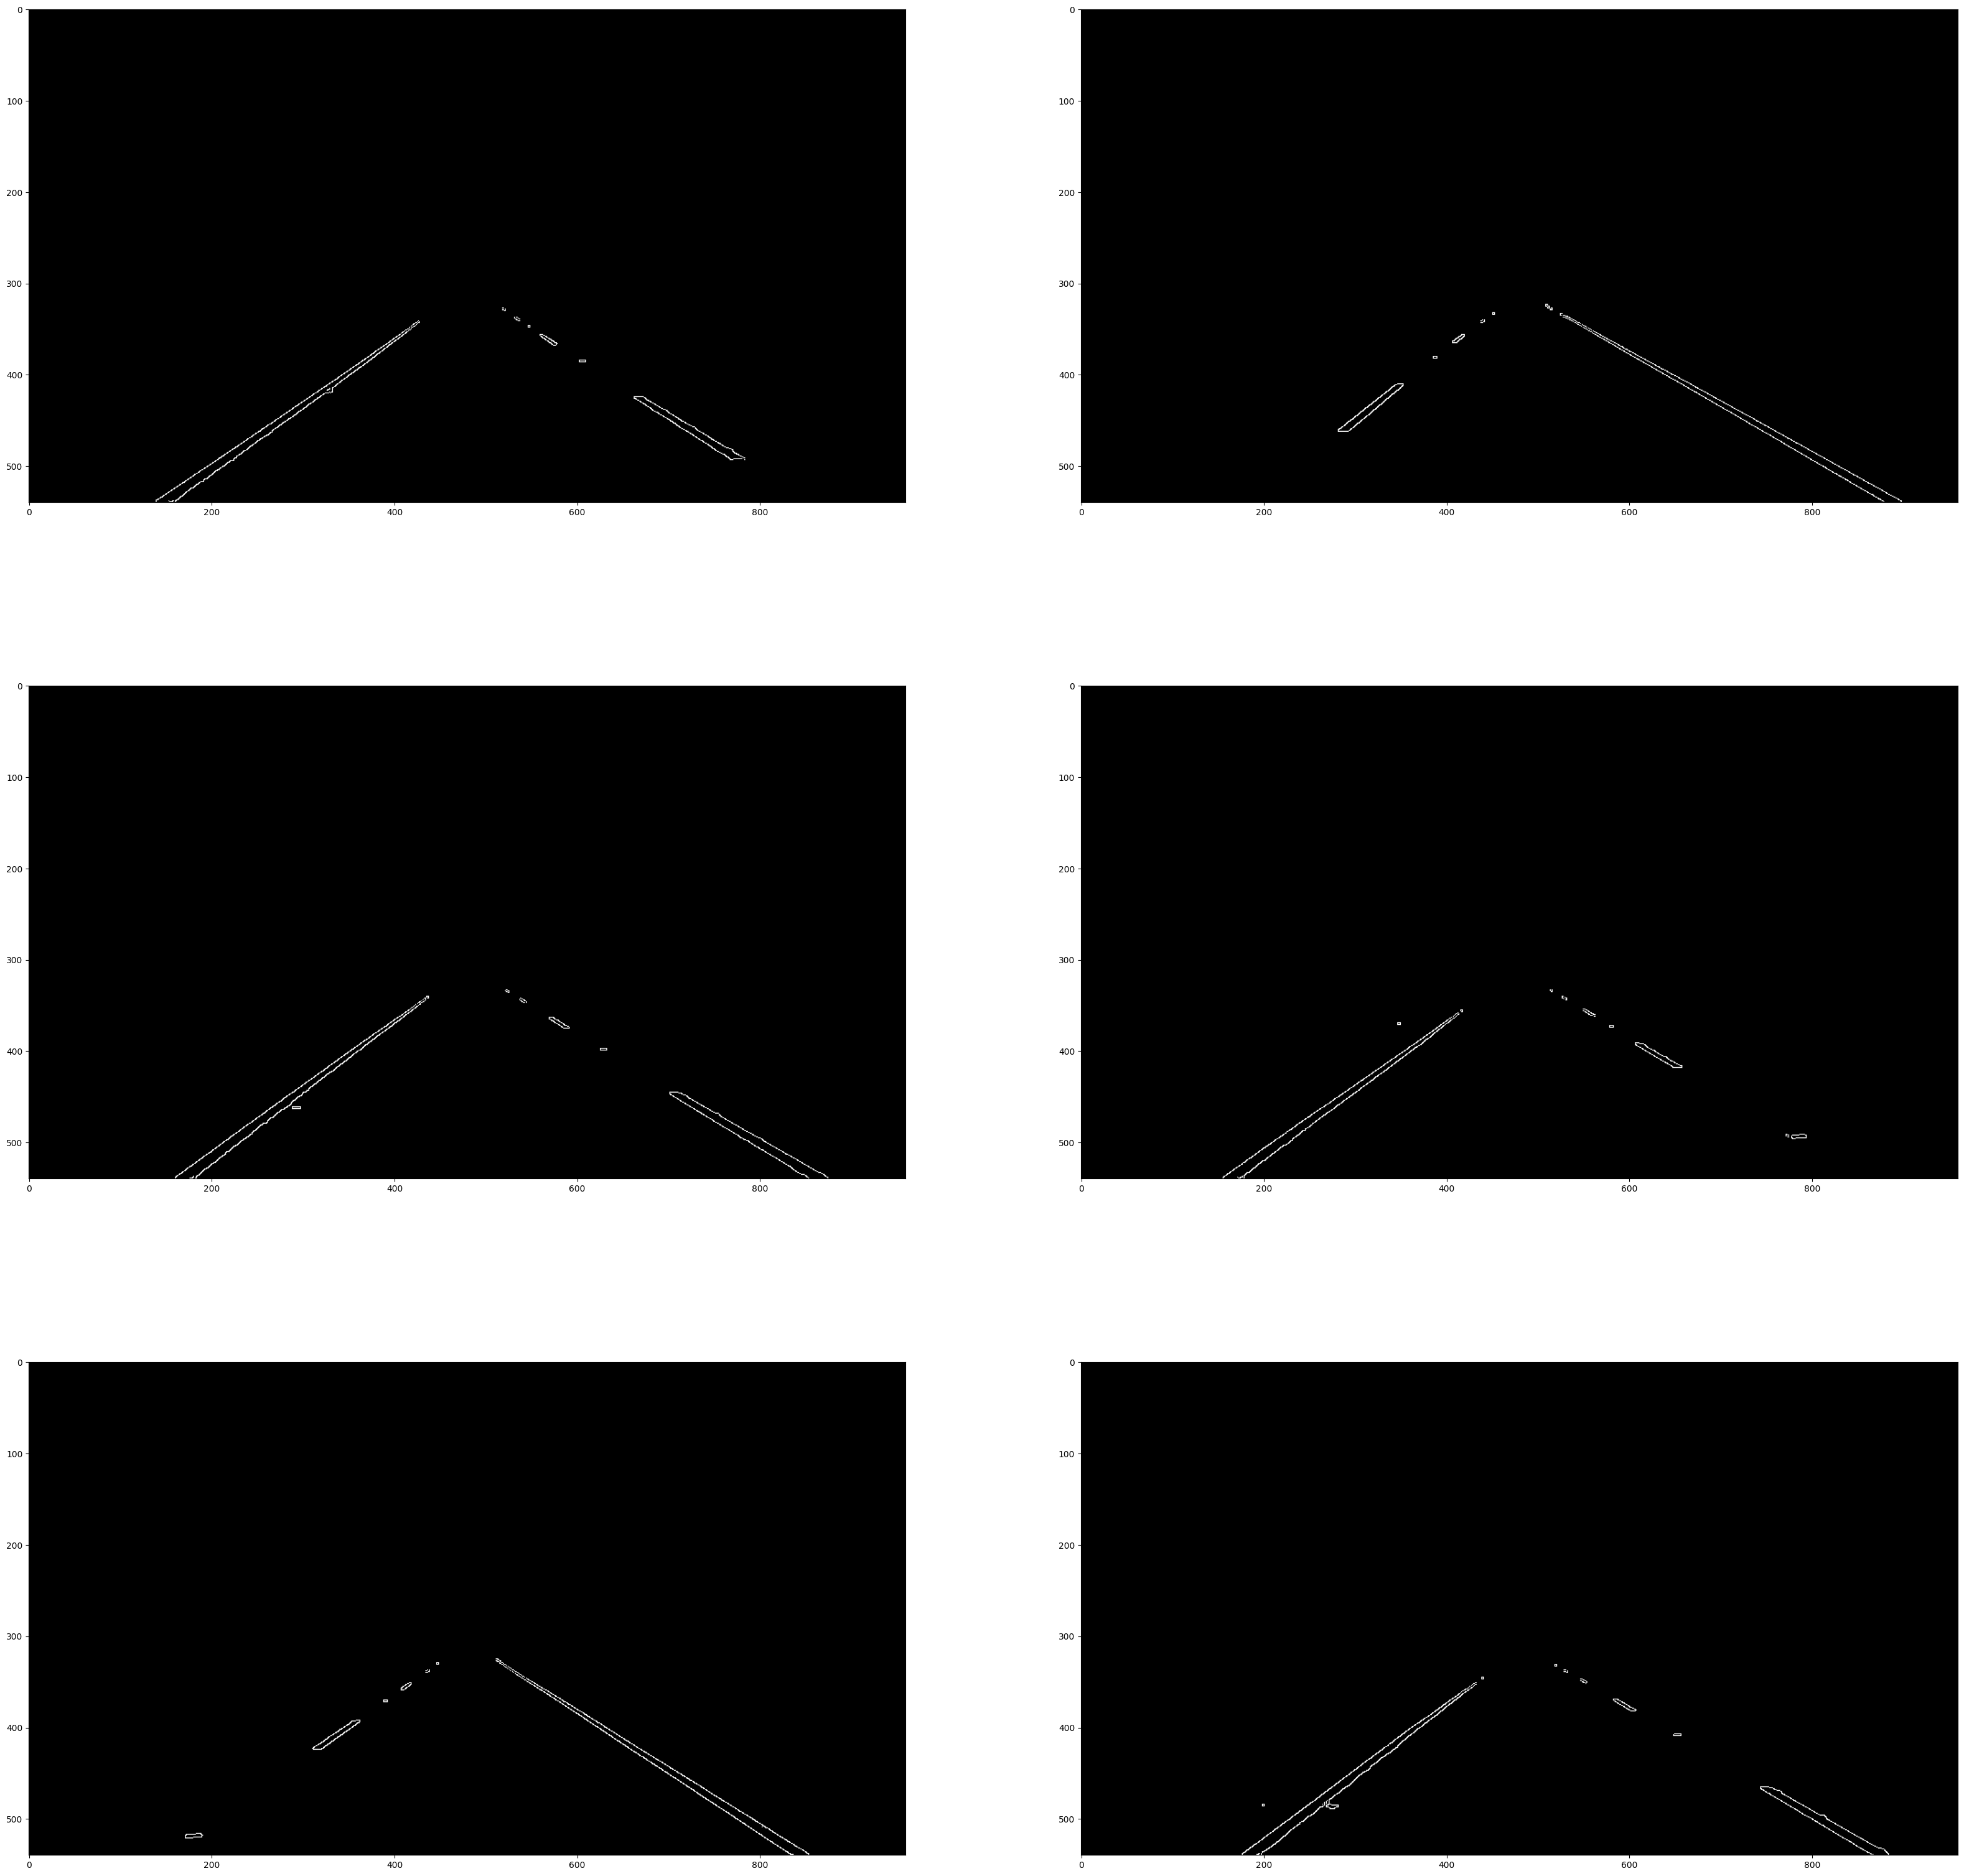

In [ ]:
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img):
  return cv2.Canny(grayscale(img), 50, 120)

canny_img = list(map(canny, roi_img))
display_images(canny_img, cmap='gray')

Finding lines
-computing lines using houghlines and filtering out lines.

Remove lines outside of determined slope range, and zone. Filter lines corresponding to wheter they have postive or negative slope.

-averaging slope and intercepts to produce one line


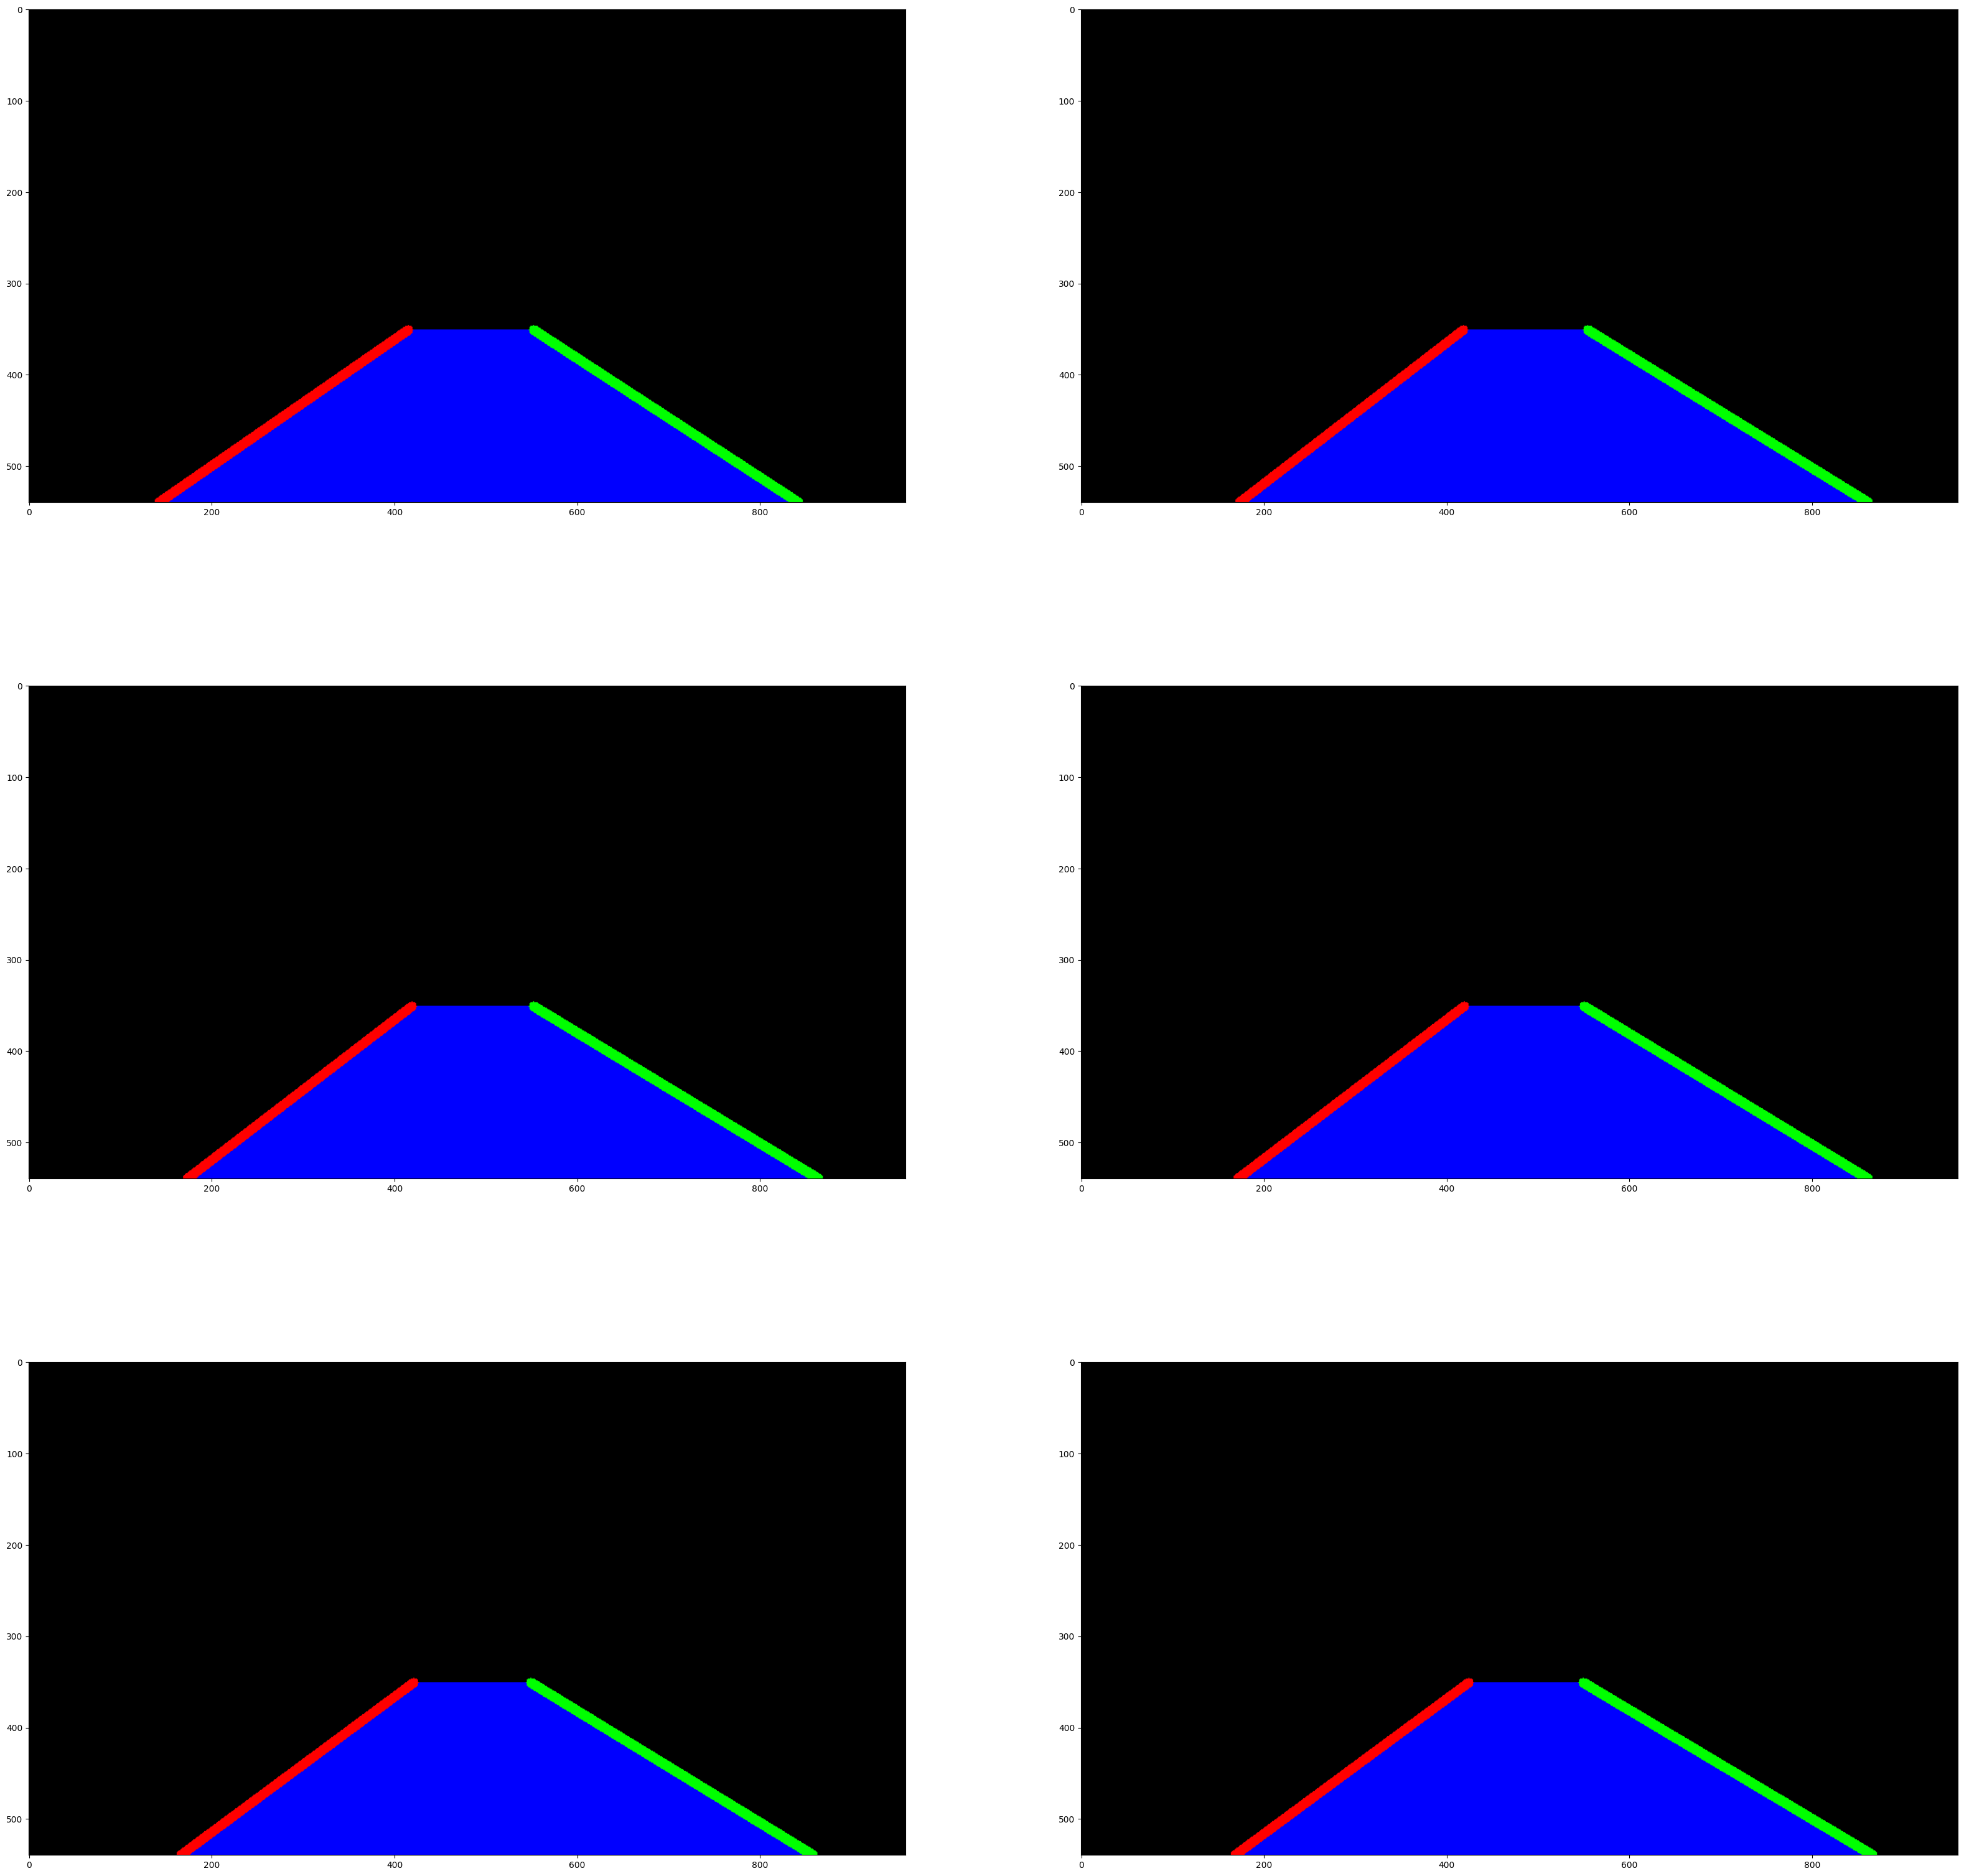

In [ ]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept
    rightColor=[0,255,0]
    leftColor=[255,0,0]

    #this is used to filter out the outlying lines that can affect the average
    #We then use the slope we determined to find the y-intercept of the filtered lines by solving for b in y=mx+b
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)


    #We use slicing operators and np.mean() to find the averages of the 30 previous frames
    #This makes the lines more stable, and less likely to shift rapidly
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])

    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])


    #Here we plot the lines and the shape of the lane using the average slope and intercepts
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)

        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))


        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), leftColor, 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])), rightColor, 10)
    except ValueError:
            #I keep getting errors for some reason, so I put this here. Idk if the error still persists.
        pass




def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_img = list(map(linedetect, canny_img))
display_images(hough_img)

Overlaying the Image and Lines    

In [ ]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weightSum, zip(hough_img, imageList)))
display_images(result_img)

Output hidden; open in https://colab.research.google.com to view.

Apply to video


In [ ]:
def processImage(image):
    interest = roi(image)
    filterimg = color_filter(interest)
    canny = cv2.Canny(grayscale(filterimg), 50, 120)
    myline = hough_lines(canny, 1, np.pi/180, 10, 20, 5)
    weighted_img = cv2.addWeighted(myline, 1, image, 0.8, 0)

    return weighted_img

In [ ]:
#challenge.mp4
#solidWhiteRight.mp4
#solidYellowLeft.mp4

output1 = 'test_videos_output/solidYellowLeft.mp4'
output2 = 'test_videos_output/solidWhiteRight.mp4'
output3 = 'test_videos_output/challenge.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")#.subclip(3,5)
clip2 = VideoFileClip("test_videos/solidWhiteRight.mp4")#.subclip(3,5)
clip3 = VideoFileClip("test_videos/challenge.mp4")#.subclip(3,5)
pclip1 = clip1.fl_image(processImage) #NOTE: this function expects color images!!
pclip2 = clip2.fl_image(processImage) #NOTE: this function expects color images!!
pclip3 = clip3.fl_image(processImage) #NOTE: this function expects color images!!
%time pclip1.write_videofile(output1, audio=False)
%time pclip2.write_videofile(output2, audio=False)
%time pclip3.write_videofile(output3, audio=False)

t:   1%|          | 2/251 [00:27<58:01, 13.98s/it, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4




t:   1%|          | 2/251 [01:27<3:01:03, 43.63s/it, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 14.1 s, sys: 1.71 s, total: 15.8 s
Wall time: 59.3 s
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4




t:   1%|          | 2/251 [01:42<3:32:05, 51.10s/it, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 4.14 s, sys: 563 ms, total: 4.7 s
Wall time: 15 s
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4




t:   1%|          | 2/251 [02:25<5:01:37, 72.68s/it, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 8.67 s, sys: 856 ms, total: 9.52 s
Wall time: 43.2 s


In [ ]:
HTML("""
<h1>solidYellowLeft.mp4</h1><video width="960" height="540" controls>
<source src="{0}">
</video>
""".format(output1))

In [ ]:
HTML("""
<h1>solidWhiteRight.mp4</h1><video width="960" height="540" controls>
<source src="{0}">
</video>
""".format(output2))

In [ ]:
HTML("""
<h1>challenge.mp4</h1><video width="960" height="540" controls>
<source src="{0}">
</video>
""".format(output3))

Pipeline:

1) Mask out everything excluding Lane Lines
2) Crop out t
he Region of Interest
3) Apply Canny Edge Detection
4) Compute the Hough Lines
5) Filter out and differentiate lines
6) Compute 2 main lines
7) Average main lines over previous frames
8) Overlay Lines and Lane over original input